# Tarea Examen 2

Nombre: Román Tamez Vidal Tamayo Tamez

### Física Computacional 2025-2

Resuelva los siguientes ejercicios.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

In [2]:
import matplotlib
# Para el formato de las gráficas
matplotlib.rcParams.update(
    {
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "axes.unicode_minus": False,
        "font.size": 12,
        "pgf.preamble": "\n".join([ # Aún más formato
        r"\usepackage[utf8]{inputenc}",
        r"\usepackage[T1]{fontenc}",
        ])
    }
)

### Problema 1
Se tiene un oscilador armónico en dos dimensiones ($xy$) en el que la fuerza está dada por $\vec{F} = -k \vec{r}$ y se tiene una fricción 

$$
\vec{f}_{\text{fric}} = 
\begin{cases}
-\gamma \vec{v} & \text{si } |\vec{v}| \leq 1 \\
-\mu v^2 \hat{v} & \text{si } |\vec{v}| > 1 \,,
\end{cases}
$$

donde $m = 1$, $k = 1$, $\gamma = 0.15$ y $\mu = 0.25$. Resuelva los siguientes ejercicios:

#### Inciso a)
Encuentre las ecuaciones de movimiento en coordenadas cartesianas. No es necesario resolver las ecuaciones.

Por Newton se tiene que
$$
m\frac{d^2\vec{r}}{dt^2} = \vec{F} + \vec{f}_{\text{fric}}\,.
$$

Notando que  $v = |\vec{v}| = \sqrt{v_x^2 + v_y^2} = \sqrt{\left(\frac{dx}{dt}\right)^2 + \left(\frac{dy}{dt}\right)^2}$ y $\vec{v} = v\hat{v}$, se separa la ecuación en términos de cada componente.

$$
m \frac{d^2 x}{dt^2} = -kx + 
\begin{cases}
-\gamma \frac{dx}{dt} & \text{si } v \leq 1 \\
-\mu v \frac{dx}{dt} & \text{si } v > 1
\end{cases}
$$

$$
m\frac{d^2 y}{dt^2} = -ky + 
\begin{cases}
-\gamma \frac{dy}{dt} & \text{si } v \leq 1 \\
-\mu v \frac{dy}{dt} & \text{si } v > 1
\end{cases}
$$

In [3]:
constantes = [1.0, 1.0, 0.15, 0.25]
def edo_1(t, sol, consts = constantes):
    # sol = [x, y, vx, vy] donde vx = dx/dt y vy = dy/dt
    x, y, vx, vy = sol
    # consts = [m, k, gma, mu]
    m, k, gma, mu = consts

    v = (vx**2 + vy**2)*0.5
    if v <= 1:
        fric = [-gma*vx, -gma*vy]
    else: 
        fric = [-mu*v*vx, -mu*v*vy]

    dvxdt = (-k*x + fric[0])/m
    dvydt = (-k*y + fric[1])/m
    return np.array([vx, vy, dvxdt, dvydt])

#### Inciso b)
Utilice el método de Runge-Kutta de 4to orden para encontrar la solución a las ecuaciones de movimiento con condiciones iniciales $\vec{r}_0 = (0, 1)$ y $\vec{v}_0 = (2\cos\theta, 2\sin\theta)$, donde $\theta = \frac{n\pi}{6}$ con $n = 0, 1, 2, \ldots, 11$.

In [4]:
def integrar_RK4(f, ts, sol0):
    """
    Integra la EDO usando el método de Runge-Kutta de cuarto orden.
    f: función que define el sistema
    ts: tiempos
    sol0: condiciones iniciales
    """
    sols = np.zeros((len(ts), len(sol0)))
    sols[0] = sol0
    h = abs(ts[1]-ts[0])

    for i in range(1, len(ts)):
        t, sol = ts[i-1], sols[i-1]
        # Kuttas
        k1 = f(t        , sol)
        k2 = f(t + 0.5*h, sol + 0.5*h*k1)
        k3 = f(t + 0.5*h, sol + 0.5*h*k2)
        k4 = f(t +     h, sol +     h*k3)
        # Runges
        sols[i] = sol + h*f(t+h/2 ,sol + (h/6)*(k1+2*k2+2*k3+k4))

    return sols

In [5]:
# Condiciones iniciales
t0, tf = 0, 10  # Tiempo inicial y final
h = 0.01  # Paso de tiempo
ts = np.arange(t0, tf, h)

r = [0, 1] # x, y
vs = [[2*np.cos(n*np.pi/6), 2*np.sin(n*np.pi/6)] for n in range(12)] # vx, vy
sol0_all = [[r[0], r[1], v[0], v[1]] for v in vs] # x, y, vx, vy

In [6]:
sols_all = [integrar_RK4(edo_1, ts, sol0) for sol0 in sol0_all]

#### Inciso c)
Genere una función que calcule la energía para las distintas condiciones iniciales y detenga la simulación cuando ésta sea menor al 30\% de su valor inicial. Asegúrese de que el error en la trayectoria no tenga variaciones de más del 0.1\%.

In [7]:
def energia_1(sol, consts = constantes):
    # sol = [x, y, vx, vy] donde vx = dx/dt y vy = dy/dt
    x, y, vx, vy = sol
    # consts = [m, k, gma, mu]
    m, k = consts[0], consts[1]

    r = (x**2 + y**2)*0.5
    v = (vx**2 + vy**2)*0.5
    T = 0.5 * m *  v**2
    U = 0.5 * k * r**2
    return  T - U

In [8]:
def simular_energia(edo,ts, sol0, goal=0.3):
    '''
    Simula hasta que la energía del sistema sea 
    30% la inicial
    '''
    # Inicialización
    sols = np.zeros((len(ts), len(sol0)))
    enes = np.zeros(len(ts))

    paso_t = [ts[0], ts[1]]
    paso_sol = integrar_RK4(edo, paso_t, sol0)
    sols[0], sols[1] = paso_sol[0], paso_sol[1]

    enes[0] = energia_1(paso_sol[0])
    ene_goal = enes[0]*goal     # Mucho ojo. Ojo cuidado!!!
    enes[1] = energia_1(paso_sol[1]) 
    
    i = 1
    while (enes[i] > ene_goal  and i < (len(ts) - 2)):
        paso_t = [ts[i], ts[i+1]]
        paso_sol = integrar_RK4(edo, paso_t, sols[i])
        sols[i+1] = paso_sol[1]
        enes[i+1] = energia_1(sols[i+1]) 

        i += 1

    return ts[:i+1], sols[:i+1], enes[:i+1]


def obtener_tf(edo_func, args, sols0, h = 0.1 ,t0=0, goal = 0.3):
    """
    Simula el sistema para cada una de las condiciones iniciales
    hasta que se llega a una energía 'goal' veces menor a la inicial
    """
    edo = lambda t, sol: edo_func(t, sol, args)
    N_sols = len(sols0)
    
    # Inicializacion
    tf = t0 + 100
    ts = np.arange(t0, tf, h)
    data_all = ['']*N_sols # jiji

    for i in range(N_sols):
        data_all[i] = simular_energia(edo, ts, sols0[i], goal)

    return data_all

El método RK4 tiene un error de $h^5$. Para el cálculo de las energías se tomará $h=0.01$, por lo que podemos asegurar que el error de las trayectorias es menor al 0.1\%.

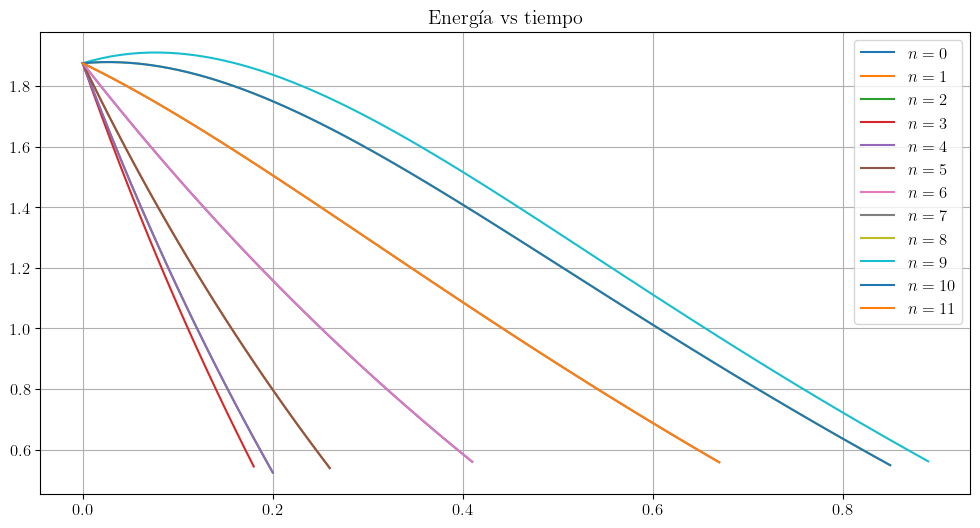

In [9]:
constantes = [1.0, 1.0, 0.15, 0.25]
data_all = obtener_tf(edo_1, constantes, sol0_all, 0.01)

# Graficas
plt.figure(figsize=(12,6))
plt.title("Energía vs tiempo")
for i in range(len(data_all)):
    tiempos, soluciones, energias = data_all[i]

    plt.plot(tiempos, energias, label=r"$n={}$".format(i))
    
plt.grid(), plt.legend()
plt.show()

#### Inciso d)
Dibuje las gráficas del momento angular para los casos del inciso (b).

In [10]:
def L_angular(sol, consts = constantes):
    # sol = [x, y, vx, vy] donde vx = dx/dt y vy = dy/dt
    x, y, vx, vy = sol
    # consts = [m, k, gma, mu]
    m = consts[0]
    return (x*vy - y*vx)*m
    
def func_arreglo(ts, func_args, func ,consts = constantes):
    arr = np.zeros_like(ts)
    for i in range(len(ts)):
        arr[i] = func(func_args[i], consts)
    return arr

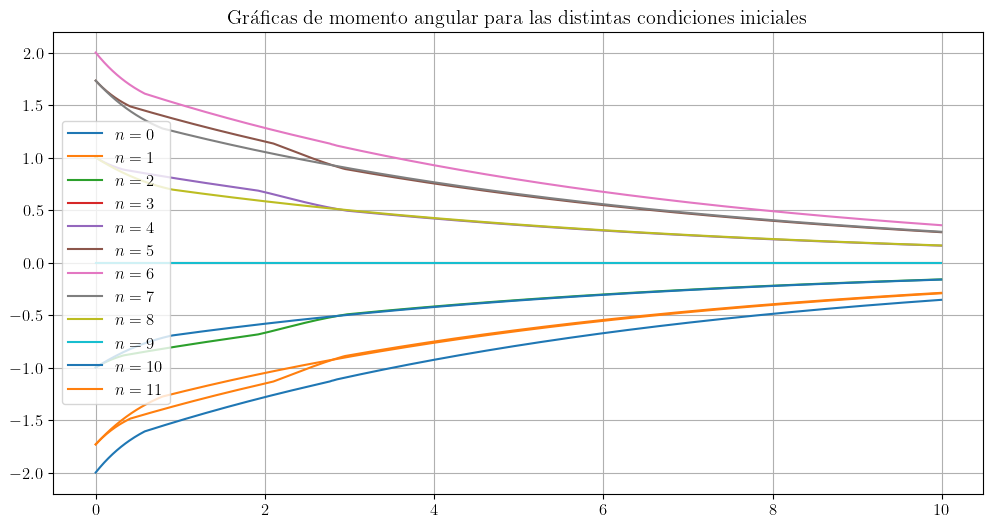

In [11]:
L_angulares_all = [func_arreglo(ts, sols, L_angular) for sols in sols_all]
# Graficas
plt.figure(figsize=(12,6))
plt.title("Gráficas de momento angular para las distintas condiciones iniciales")
for i in range(len(L_angulares_all)):
    plt.plot(ts, L_angulares_all[i], label=r"$n={}$".format(i))
    
plt.grid(), plt.legend()
plt.show()

#### Inciso e)
Tome de manera arbitraria alguna condición inicial y dibuje el espacio fase $(p_x, x)$.

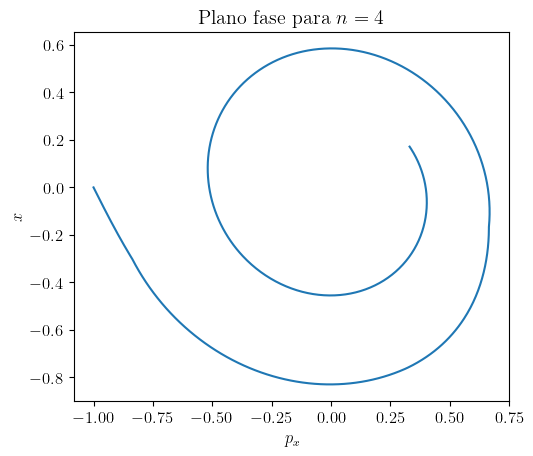

In [12]:
ind = np.random.randint(0,12)
x = sols_all[ind][:,0]
px = sols_all[ind][:,2] * constantes[0]

plt.plot(px,x)
plt.title(r'Plano fase para $n={}$'.format(ind))
plt.xlabel(r'$p_x$'), plt.ylabel(r'$x$')
plt.gca().set_aspect('equal')
plt.show()

### Problema 2
Suponga que se tienen dos partículas de masa $m$ y que una de ellas se encuentra anclada en el origen. La fuerza entre ellas es de tipo resorte con fuerza $\vec{F} = -k\vec{r}$. Además, ambas partículas tienen carga $q > 0$ y por lo tanto también interactúan por fuerza de Coulomb.

***Nota:** No considere el caso relativista ni la generación de campos magnéticos producidos por el movimiento de las partículas.*

In [30]:
constantes = [1.0, 1.0, 0.5, 0] #  [m, k, q, gma]
def edo_2(t, sol, consts=constantes):
    # sol = [x, y, vx, vy] donde vx = dx/dt y vy = dy/dt
    x, y, vx, vy = sol
    m, k, q, gma = consts

    r3_2 = (x**2 + y**2)**1.5
    dvxdt = (-k*x + (q**2) * x / r3_2 - gma*vx)/m
    dvydt = (-k*y + (q**2) * y / r3_2 - gma*vy)/m
    return np.array([vx, vy, dvxdt, dvydt])

def energia_2(sol, consts=constantes):
    x, y, vx, vy = sol
    m, k, q, gma = consts

    r = (x**2 + y**2)**0.5
    v2 = vx**2 + vy**2
    return 0.5*m*v2 - (0.5*k*r**2 + (q**0.5)/r)

def pot_eff(sol, consts=constantes):
    x, y, vx, vy = sol
    m, k, q, gma = consts

    r2 = x**2 + y**2
    U_cent = 0.5 * L_angular(sol, constantes)**2/r2
    U_hc = -(0.5*k*r2 + q/(r2**0.5))
    return U_cent + U_hc

def pot_eff_r(r,ci, consts=constantes):
    m, k, q, gma = consts
    U_cent = (0.5*L_angular(ci, consts)**2)/r**2
    U_hc = -(0.5*k*r**2 + q/r)
    return U_cent + U_hc

#### Inciso a)
Sin considerar la fricción, ¿el sistema puede tener órbitas cerradas? De ser así, encuentre algunas de estas órbitas o muestre que el sistema no puede tener este tipo de órbitas. (Apoye sus argumentos con algunas simulaciones).

E = -70.191
E = -69.891
E = -69.711
E = -69.491
E = -69.086


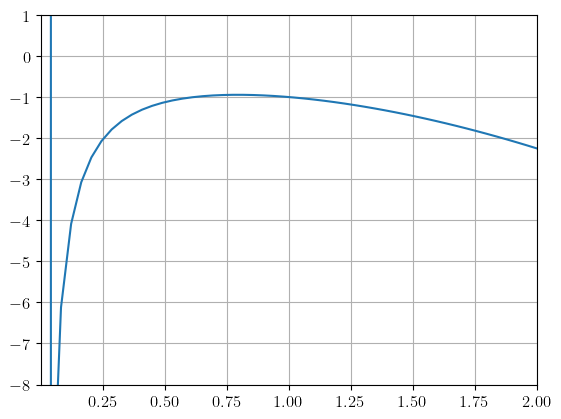

In [50]:
vxs = [0.2,0.8,1.0,1.2,1.5]
r = np.linspace(1e-8,2)
for vx in vxs:
    ci = np.array([0.01,0,vx,1])
    E = energia_2(ci)
    print("E = {:.3f}".format(E))
    plt.hlines(E,r[0],r[-1])

P_eff = func_arreglo(r, r, pot_eff_r, ci)

plt.plot(r,P_eff)
plt.xlim(r[0],r[-1]),plt.ylim(-8,1)
plt.grid()
plt.show()

El púnto crítico que se muestra en el potencial efectivo es un máximo y por lo tanto no se puede asegurar que hayan órbitas cerradas estables.

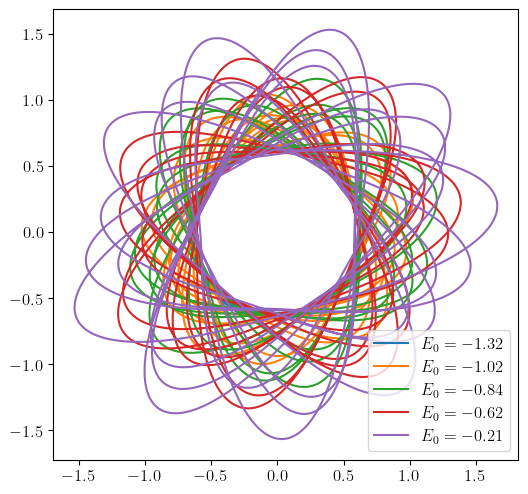

In [ ]:
ts = np.arange(0,30*np.pi,0.01)
plt.figure(figsize=(6,6))
for vx in vxs:
    ci = np.array([0,0.617,vx,0])
    E = energia_2(ci)
    sols = integrar_RK4(edo_2, ts, ci)
    x , y = sols[:,0], sols[:,1]
    plt.plot(sols[:,0], sols[:,1],label=r'$E_0 = {:.2f}$'.format(E))
    
plt.legend(), plt.gca().set_aspect('equal')
plt.show()

Las órbitas son cerradas en el sentido de que la partícula no puede escapar debido al potencial del resorte, pero no son estables porque no se puede regresar a la misma condición inicial.

#### Inciso b) 
Considerando fricción proporcional a la velocidad, ¿el sistema puede tener órbitas cerradas? De ser así, encuentre algunas de estas órbitas o muestre que el sistema no puede tener este tipo de órbitas. (Apoye sus argumentos con algunas simulaciones).

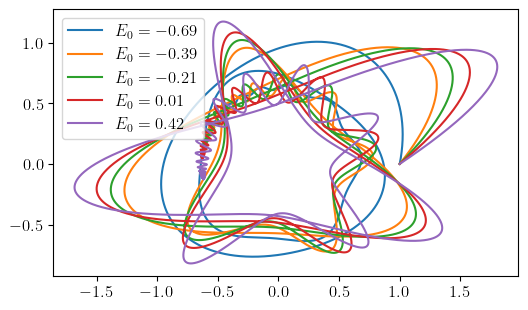

In [54]:
constantes = [1.0, 1.0, 0.5, 0.10]
ts = np.arange(0,60*np.pi,0.01)

plt.figure(figsize=(6,6))
for vx in vxs:
    ci = np.array([1,0,vx,1])
    E = energia_2(ci)
    sols = integrar_RK4(lambda t, sol: edo_2(t, sol, constantes), ts, ci)
    plt.plot(sols[:,0], sols[:,1],label=r'$E_0 = {:.2f}$'.format(E))

plt.legend(), plt.gca().set_aspect('equal')
plt.show()

La energía disminuye conforme pasa el tiempo, por lo que eventualmente se para el sistema.

### Problema 3
Se tiene una partícula de masa $m = 1$ en un campo gravitacional $\vec{g} = -9.8 \hat{j}$ en una caja como se muestra en la Figura 1 con $L = 10$ m y $d = 3$ m. Realice este problema con valores de $\alpha = \frac{\pi}{6}$ y $\alpha = \frac{\pi}{10}$.

In [55]:
# Parámetros del problema
m = 1.0  # masa
g = 9.8  # aceleración gravitacional
L = 10.0  # ancho de la caja
d = 3.0   # altura sobre la rampa
d_old = 3.0

# edo de movimiento
def movimiento(t, estado, alpha):
    x, y, vx, vy = estado
    dxdt = vx
    dydt = vy
    dvxdt = 0.0
    dvydt = -g
    return [dxdt, dydt, dvxdt, dvydt]

# Ángulos alpha a simular
alphas = [np.pi/6, np.pi/10]
alphas_str = [r"\pi / 6", r"\pi / 10"]

def dibujar_caja_rampas(ax, alpha):
    x_rampa_d = np.linspace(0, L/2, 100)
    y_rampa_d = np.tan(alpha)*x_rampa_d
    ax.plot(x_rampa_d, y_rampa_d, 'k-', linewidth=2)
    x_rampa_i = np.linspace(-L/2, 0, 100)
    y_rampa_i = np.tan(-alpha)*x_rampa_i
    ax.plot(x_rampa_i, y_rampa_i, 'k-', linewidth=2)
    ax.plot([-L/2, -L/2], [0, d], 'k-', linewidth=2)  # Pared izquierda
    ax.plot([L/2, L/2], [0, d], 'k-', linewidth=2)   # Pared derecha
    ax.plot([-L/2, L/2], [d, d], 'k-', linewidth=2)   # Techo
    ax.plot([-L/2, L/2], [0, 0], 'k-', linewidth=2)   # Piso

#### Inciso a)
Realice una simulación con condición inicial tal que la posición inicial está sobre la rampa a un tercio de la distancia entre la pared vertical izquierda y el vértice inferior de la caja, y se dispara con velocidad $|\vec{v}| = 1$ hacia la derecha con ángulos sobre la horizontal $\alpha$, $2\alpha$ y $3\alpha$. La simulación debe incluir al menos 20 rebotes.

In [18]:
# Funciones de evento para los rebotes
def evento_rampa_derecha(t, estado, alpha):
    x, y, vx, vy = estado
    return y - np.tan(alpha) * x
evento_rampa_derecha.terminal = True
evento_rampa_derecha.direction = -1

def evento_rampa_izquierda(t, estado, alpha):
    x, y, vx, vy = estado
    return y - np.tan(-alpha) * x
evento_rampa_izquierda.terminal = True
evento_rampa_izquierda.direction = -1

def evento_pared_izquierda(t, estado, alpha):
    x, y, vx, vy = estado
    return x + L/2
evento_pared_izquierda.terminal = True
evento_pared_izquierda.direction = -1

def evento_pared_derecha(t, estado, alpha):
    x, y, vx, vy = estado
    return x - L/2
evento_pared_derecha.terminal = True
evento_pared_derecha.direction = 1

def evento_techo(t, estado, alpha):
    x, y, vx, vy = estado
    return y - d
evento_techo.terminal = True
evento_techo.direction = 1

# Manejo de colisiones
def rebote_rampa(estado, alpha):
    x, y, vx, vy = estado
    n = np.array([-np.tan(alpha), 1.0])   # Vector normal a la rampa
    n = n / np.linalg.norm(n)
    v = np.array([vx, vy])
    v_reflejado = v - 2 * np.dot(v, n) * n
    return [x, y, v_reflejado[0], v_reflejado[1]]

def rebote_pared_vertical(estado):
    x, y, vx, vy = estado
    return [x, y, -vx, vy]

def rebote_techo(estado):
    x, y, vx, vy = estado
    return [x, d, vx, -vy]

# Simulación para un ángulo alpha y un ángulo de disparo theta
def simular(fun, alpha, theta, v0 = 1.0, n_rebotes=20, restitucion=0.7):
    # Posición inicial (a un tercio de la distancia entre la pared izquierda y el vértice)
    x0 = -L/2 + L/2 * np.tan(alpha) / 3
    y0 = np.tan(-alpha)*x0 + 0.01
    # Velocidad inicial
    vx0 = v0 * np.cos(theta)
    vy0 = v0 * np.sin(theta)
    
    estado_inicial = [x0, y0, vx0, vy0]
    estados = [estado_inicial]
    tiempos = [0.0]
    t_inicio = tiempos[0]
    t_final = 10.0  # Tiempo máximo de simulación
    
    for _ in range(n_rebotes):
        sol = solve_ivp(
            fun,
            [t_inicio, t_final],
            estados[-1],
            args=(alpha,),
            events=[
                evento_rampa_izquierda,
                evento_rampa_derecha,
                evento_pared_izquierda,
                evento_pared_derecha,
                evento_techo,
            ],
            dense_output=True,
            rtol=1e-8, atol=1e-8
        )
        
        if not sol.t_events:
            break

        eventos_t = [t[0] for t in sol.t_events if t.size > 0]

        if len(eventos_t) == 0:
            break
        
        # Encontrar el primer evento que ocurre
        t_evento = min(eventos_t)
        evento_idx = [i for i, t in enumerate(sol.t_events) if t.size > 0 and t[0] == t_evento][0]
        
        # Obtener el estado en el evento
        estado_evento = sol.sol(t_evento)
        
        # Manejar el rebote según el evento
        if evento_idx == 0:  # rampa izquierda
            nuevo_estado = rebote_rampa(estado_evento, -alpha)
        elif evento_idx == 1:  # rampa derecha
            nuevo_estado = rebote_rampa(estado_evento, alpha)
        elif evento_idx == 2 or evento_idx == 3:  # paredes verticales
            nuevo_estado = rebote_pared_vertical(estado_evento)
        else:
            nuevo_estado = rebote_techo(estado_evento)

        # FRICCIÓN
        nuevo_estado[2], nuevo_estado[3] = nuevo_estado[2]*restitucion, nuevo_estado[3]*restitucion
            
        # TODO: No usar appends
        estados.append(nuevo_estado)
        tiempos.append(t_evento)
        t_inicio = t_evento
    
    # Reconstruir la trayectoria completa
    t_total = np.linspace(0, tiempos[-1], 1000)
    trayectoria = []
    for t in t_total:
        for i in range(len(tiempos) - 1):
            if tiempos[i] <= t <= tiempos[i + 1]:
                sol = solve_ivp(
                    fun,
                    [tiempos[i], tiempos[i + 1]],
                    estados[i],
                    args=(alpha,),
                    dense_output=True,
                )
                trayectoria.append(sol.sol(t))
                break
    trayectoria = np.array(trayectoria).reshape(-1, 4)
    
    return trayectoria, t_total

In [19]:
# Realizar las simulaciones y graficar
def realizar_simulaciones(velocidad_ini, restitucion):
    for i, alpha in enumerate(alphas):
        fig = plt.figure(figsize=(12, 6))
        ax = fig.subplots(1,1)

        global d
        d = d_old + L/2*np.tan(alpha) # Se obtiene la altura correcta
        
        dibujar_caja_rampas(ax, alpha)
        
        for n in range(1,4):
            trayectoria, t = simular(movimiento, alpha, alpha*n, velocidad_ini, 20, restitucion)
            ax.plot(trayectoria[:, 0], trayectoria[:, 1], label=r'$\theta = {}\times{}$'.format(n,alphas_str[i]))
            ax.plot(trayectoria[0, 0], trayectoria[0, 1], 'x') # Posicion inicial
        
        ax.set_title(f'Simulación para $\\alpha = {alphas_str[i]}$ y $v_0 = {velocidad_ini:.2f}$')
        ax.set_xlabel('x (m)'), ax.set_ylabel('y (m)')
        ax.legend(), ax.grid(), ax.axis('equal')
        plt.show()

##### Simulación

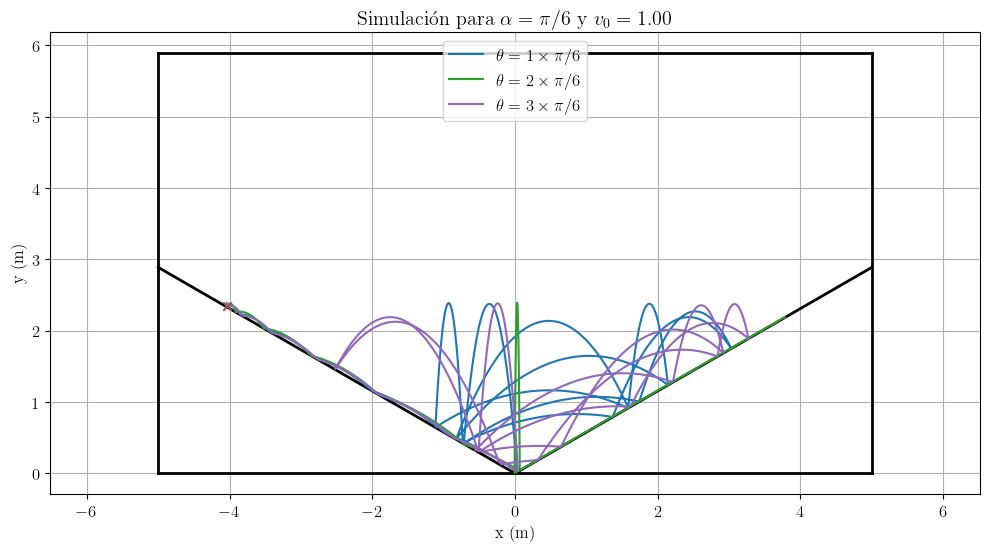

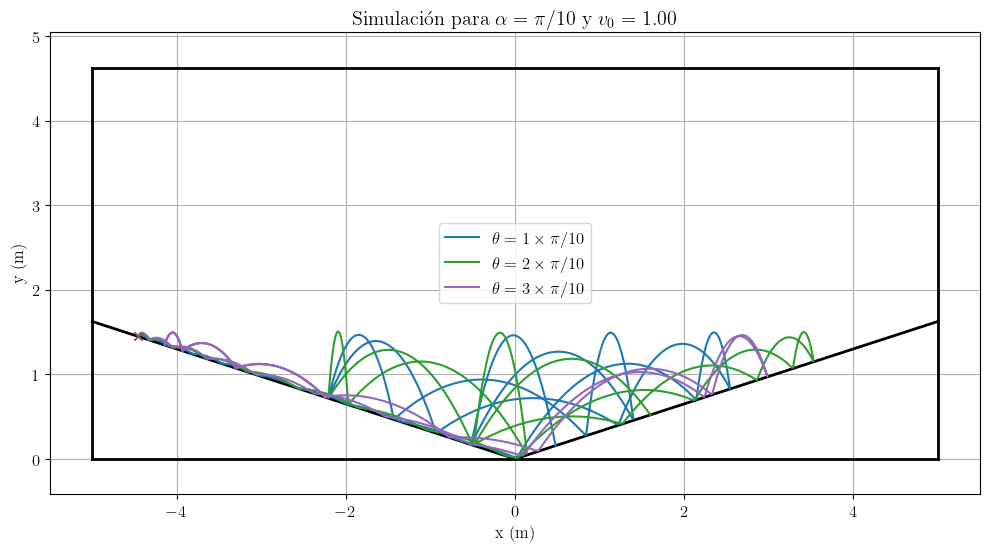

In [20]:
realizar_simulaciones(1, 1)

#### Inciso b)
Introduzca algún modelo de fricción y compare las trayectorias con el inciso anterior.

##### Simulación
El modelo de fricción a utilizado es uno de colisiones inelásticas modeladas por un coeficiente de restitución $c = \frac{\text{rapidez tras el rebote}}{\text{rapidez previo el rebote}}$.

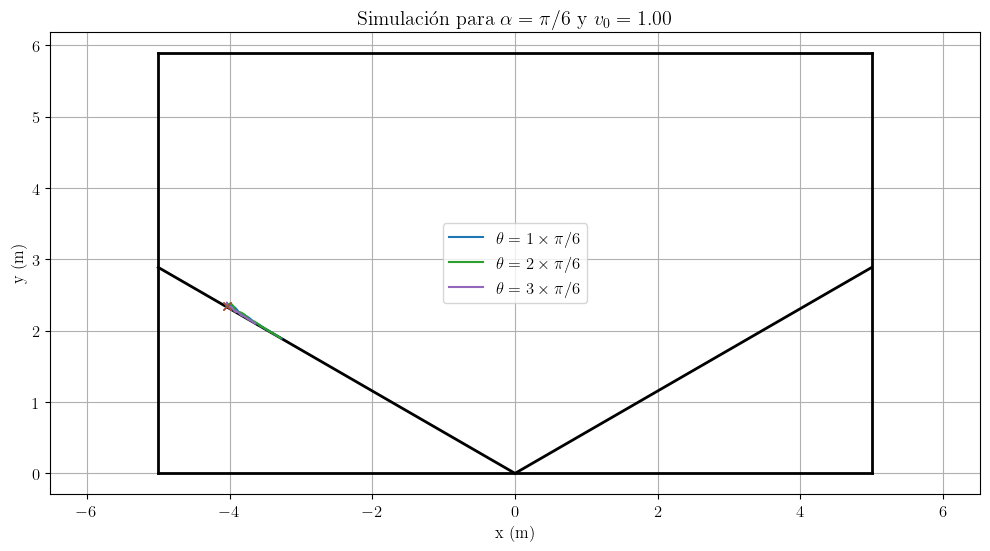

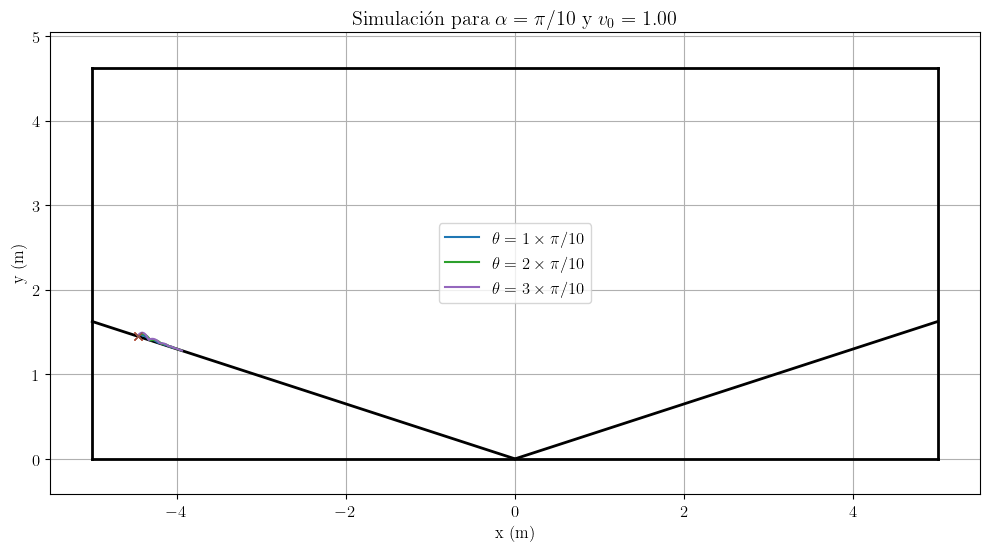

In [21]:
realizar_simulaciones(1, 0.7)

En el inciso a), la partícula llegaba a la mitad de la caja y rebotaba alcanzando la altura con la que inició. Ahora la partícula se frena.

#### Inciso c)
Realice los ejercicios en los incisos (a) y (b) pero ahora con $|\vec{v}| = 25$ y $|\vec{v}| = 60$. Describa las similitudes y diferencias entre las distintas simulaciones.

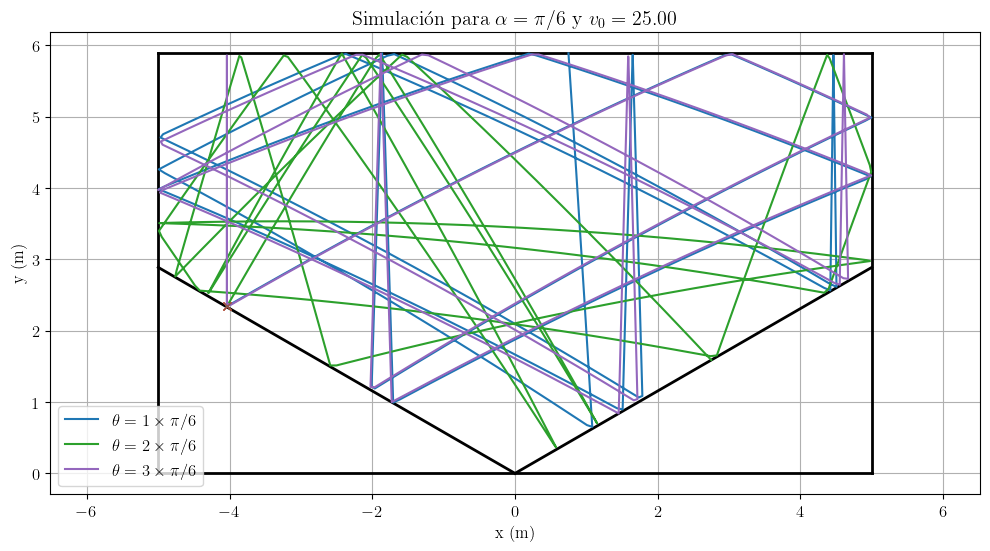

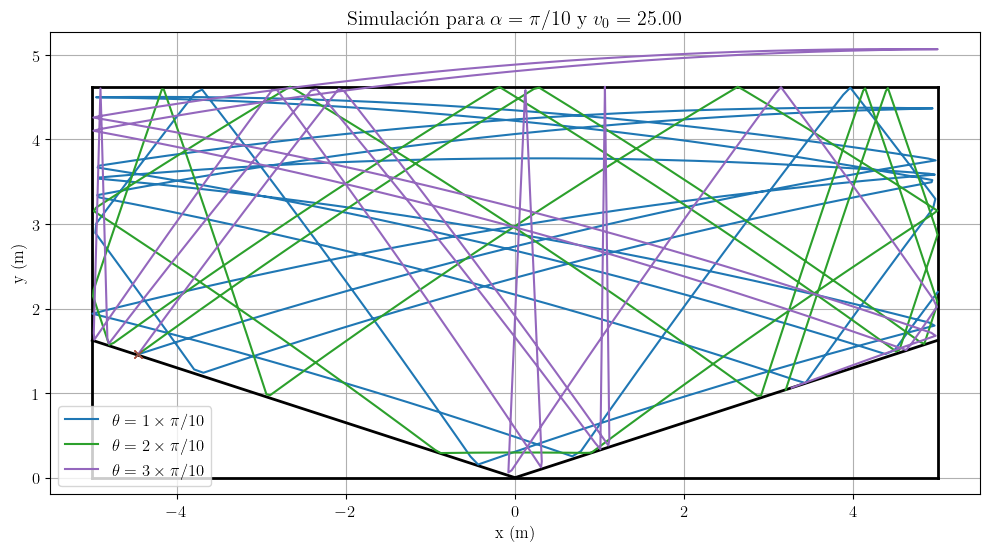

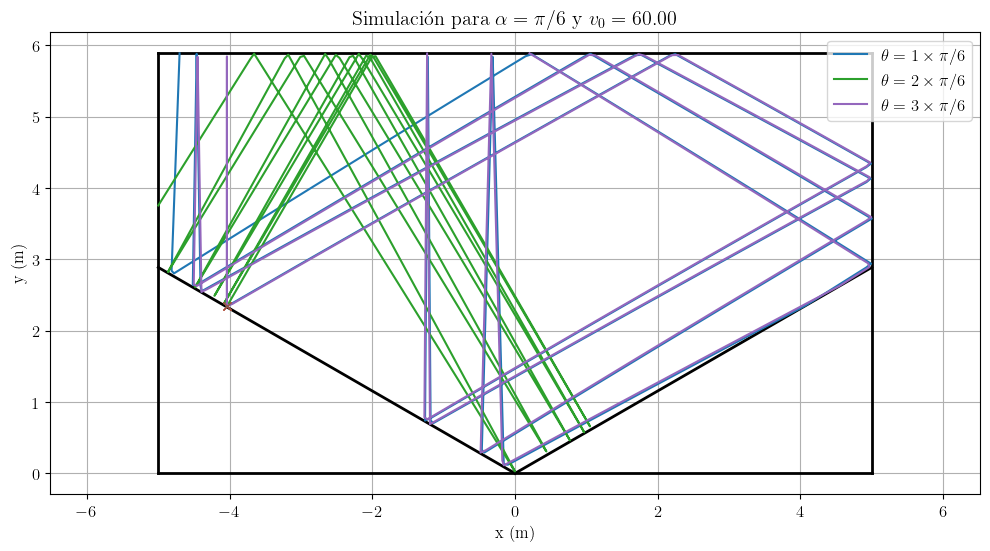

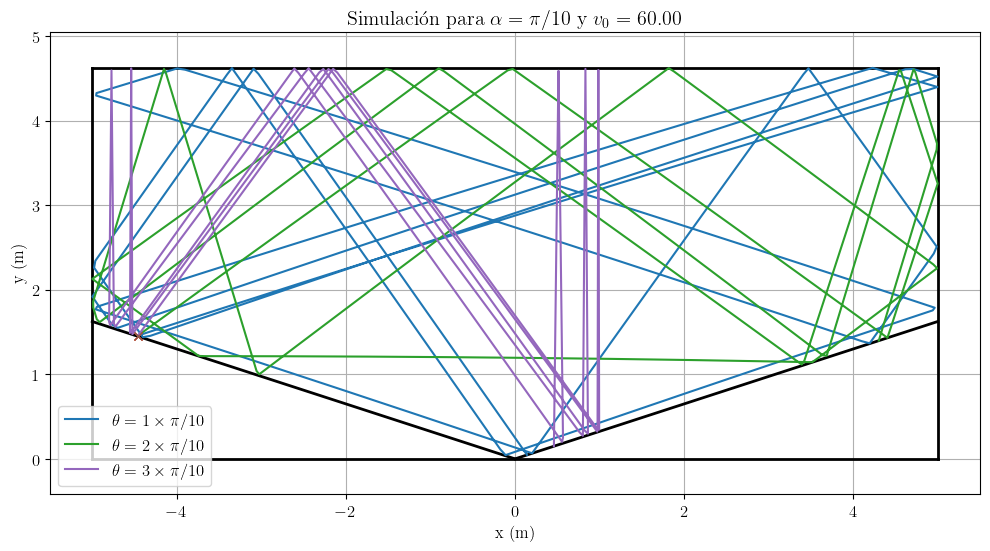

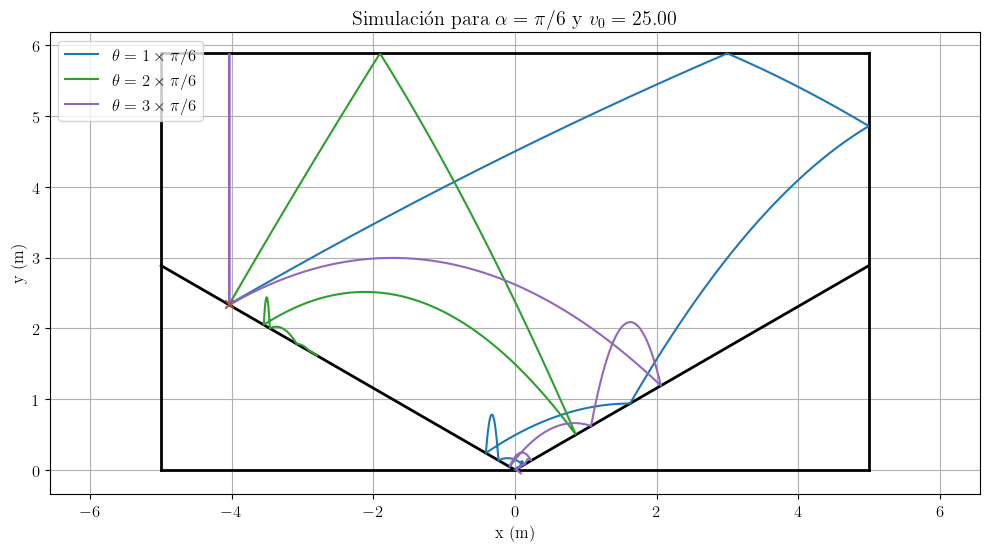

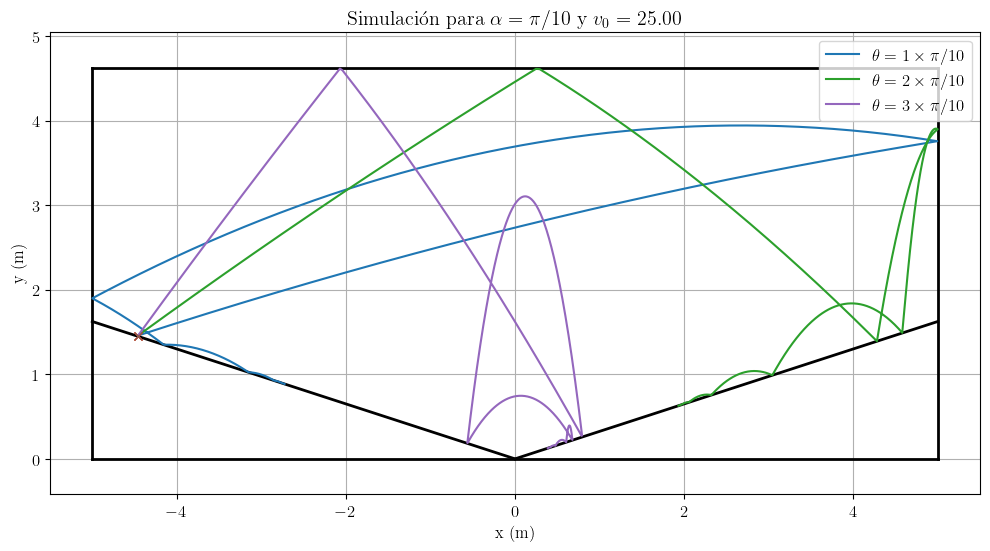

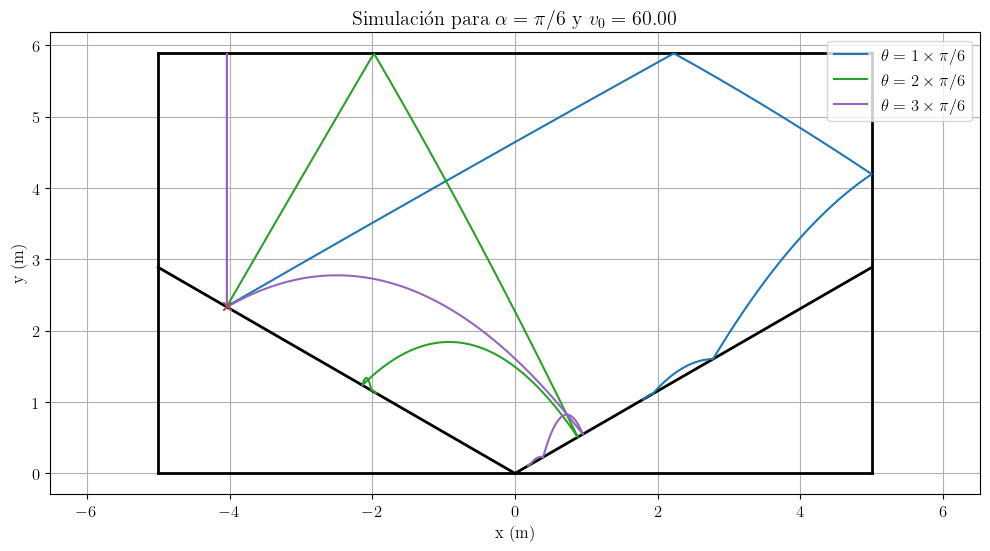

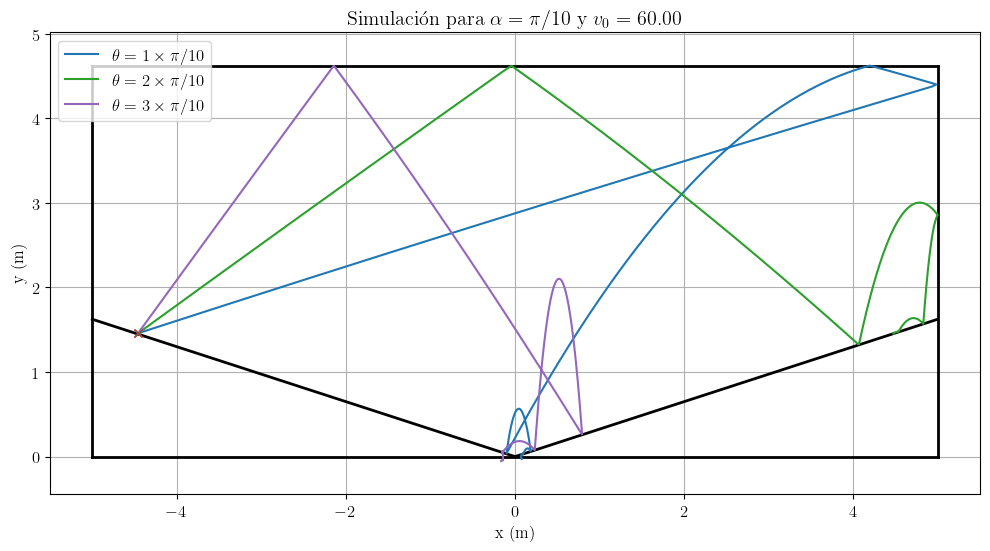

In [22]:
realizar_simulaciones(25, 1)
realizar_simulaciones(60, 1)
realizar_simulaciones(25, 0.5)
realizar_simulaciones(60, 0.3)

##### Descripción
En algunos casos el error numérico hace que no se  detecten las colisiones de manera correcta y la partícula sale de la caja. Cuando la restitución es 1 y la velocidad es de 60, las trayectorias dentro de la caja son básicamente líneas rectas.

#### Inciso d) 
Dibuje el espacio fase $(p_x, x)$ y $(p_y, y)$ cuando no hay fricción y la partícula es lanzada hacia la derecha a un ángulo $\alpha$ y vertical hacia arriba. Considere el número necesario de rebotes para barrer el espacio fase representativamente.

In [23]:
# Ángulos de tiro a simular
thetas = [np.pi/4, np.pi/2]
thetas_str = [r"\pi / 4", r"\pi / 2"]

In [24]:
#  Realizar las simulaciones y graficar
alpha_ramp = np.pi/3
alpha_ramp_str = r"\pi/3"
def dibujar_espacio_fase(velocidad_ini, restitucion):
    for i, theta in enumerate(thetas):
        fig = plt.figure(figsize=(18, 6))
        axs = fig.subplots(1,2)

        global d
        d = d_old + L/2*np.tan(theta) # Se obtiene la altura correcta
        trayectoria, t = simular(movimiento, alpha_ramp, theta, velocidad_ini, 50, restitucion)
        
        axs[0].plot(trayectoria[:, 2] * m, trayectoria[:, 0], color='r')
        axs[0].set_title(r'Espacio fase $(p_x, x)$. $\alpha={:}$, $\theta={}$, $v_0={}$.'.format(alpha_ramp_str, thetas_str[i], velocidad_ini))
        axs[0].set_xlabel(r'$p_x$'), axs[0].set_ylabel(r'$x$')
        axs[0].grid()

        axs[1].plot(trayectoria[:, 3] * m, trayectoria[:, 1], color='g')
        axs[1].set_title(r'Espacio fase $(p_y, y)$. $\alpha={}$, $\theta={}$, $v_0={}$.'.format(alpha_ramp_str, thetas_str[i], velocidad_ini))
        axs[1].set_xlabel(r'$p_y$'), axs[1].set_ylabel(r'$y$')
        axs[1].grid()
        
        plt.show()

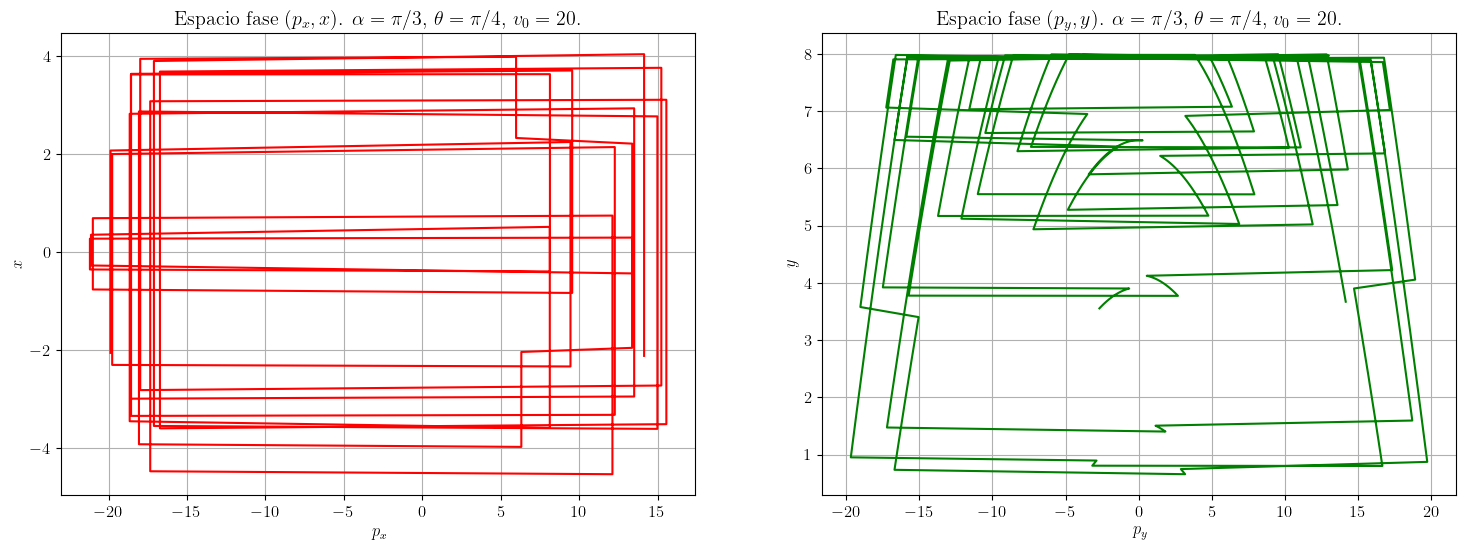

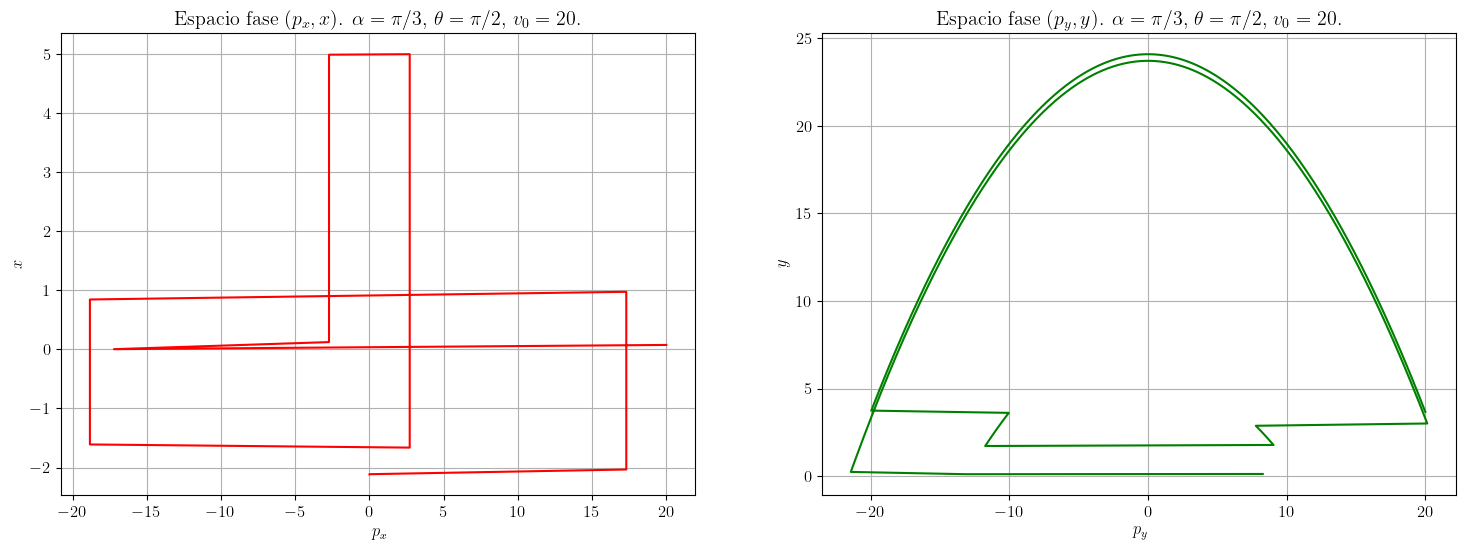

In [25]:
dibujar_espacio_fase(20, 1)

### Problema 4
Se tiene una partícula de masa $m = 1$ en una caja circular como se muestra en la Figura 2. Los radios de la caja son $a$ y $b$ tales que $b = 2a$.

In [ ]:
# Parámetros
a = 1.0
b = 2 * a
g = 9.8

# Ecuaciones de movimiento
# Ahora se utilizan coordenadas polares
def movimiento_circ(t, estado):
    r, theta, vr, vtheta = estado
    dvrdt = r * vtheta**2 - g * np.sin(theta)
    dvthetadt = (-2 * vr * vtheta - g * np.cos(theta)) / r
    return [vr, vtheta, dvrdt, dvthetadt]

#### Inciso a)
Realice una simulación en donde la partícula realiza varios rebotes en las paredes de la caja. Suponga condiciones iniciales arbitrarias que lo permitan.

In [27]:
# Eventos de colisión
def evento_r_a(t, estado):
    return estado[0] - a
evento_r_a.terminal = True
evento_r_a.direction = -1  # Detecta cuando r disminuye a 'a'

def evento_r_b(t, estado):
    return estado[0] - b
evento_r_b.terminal = True
evento_r_b.direction = 1  # Detecta cuando r aumenta a 'b'

# Manejo de colisiones
def rebote(estado, radio):
    return [radio, estado[1], -estado[2], estado[3]]  # Invierte vr, conserva vtheta

# Simulación
def simular_circ(fun, estado_inicial, t_max=10, n_rebotes=20):
    estados = [estado_inicial]
    tiempos = [0.0]
    t_inicio = tiempos[0]
    
    for _ in range(n_rebotes):
        sol = solve_ivp(
            fun,
            [t_inicio, t_max],
            estados[-1],
            events=[evento_r_a, evento_r_b],
            dense_output=True,
            rtol=1e-8, atol=1e-8,
        )
        
        # Salimos si no ha habido colisiones
        if not sol.t_events[0].size and not sol.t_events[1].size:
            break
        
        # Se determina qué evento ocurrió primero
        t_evento = min([t[0] for t in sol.t_events if t.size > 0])
        evento_idx = [i for i, t in enumerate(sol.t_events) if t.size > 0 and t[0] == t_evento][0]
        
        estado_evento = sol.sol(t_evento)
        
        # Aplicar rebote
        if evento_idx == 0:  # r = a
            nuevo_estado = rebote(estado_evento, a)
        else:  # r = b
            nuevo_estado = rebote(estado_evento, b)
        
        estados.append(nuevo_estado)
        tiempos.append(t_evento)
        t_inicio = t_evento
    
    # Reconstruir la trayectoria
    t_total = np.linspace(0, tiempos[-1], 1000)
    trayectoria = []
    for t in t_total:
        for i in range(len(tiempos) - 1):
            if tiempos[i] <= t <= tiempos[i + 1]:
                sol = solve_ivp(
                    fun,
                    [tiempos[i], tiempos[i + 1]],
                    estados[i],
                    dense_output=True
                )
                trayectoria.append(sol.sol(t))
                break
    trayectoria = np.array(trayectoria).reshape(-1, 4)
    
    return trayectoria, t_total

In [28]:
def realizar_simulaciones_circ(estado_inicial, t_max, rebotes):
    # Simular y graficar
    trayectoria, t = simular_circ(movimiento_circ, estado_inicial, t_max, rebotes)

    # Convertir a cartesianas para graficar
    x = trayectoria[:, 0] * np.cos(trayectoria[:, 1])
    y = trayectoria[:, 0] * np.sin(trayectoria[:, 1])

    plt.figure(figsize=(6, 6))
    plt.plot(x, y, label="Trayectoria", color='tab:orange')
    plt.plot(x[0], y[0], 'x') # Posicion inicial
    plt.gca().add_patch(plt.Circle((0, 0), a, fill=False, color='k', linewidth=2))
    plt.gca().add_patch(plt.Circle((0, 0), b, fill=False, color='k', linewidth=2))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Partícula afectada por la gravedad confinada entre dos círculos")
    plt.axis('equal')
    plt.legend()
    plt.grid()
    plt.show()

##### Simulación

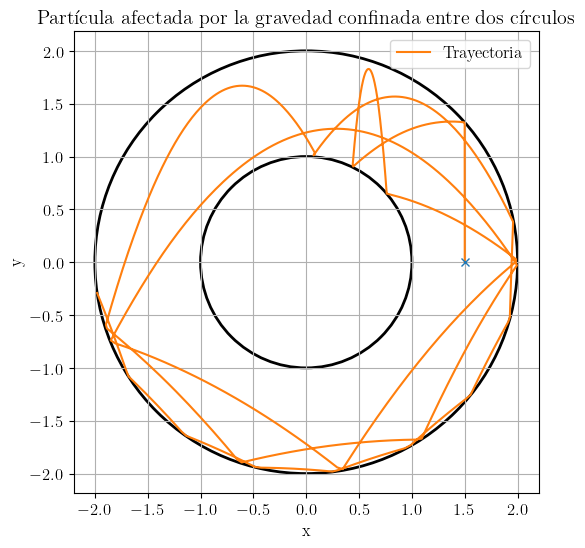

In [29]:
g = 9.8
realizar_simulaciones_circ([1.5, 0, 0, 4], 10, 20) # r, θ, vr, vθ

#### Inciso b)
¿Existen condiciones iniciales que hagan que la partícula quede encasillada en sólo un sector de la caja? De ser así, muestre cuáles son tales condiciones o justifique por qué no se puede obtener dicha situación.

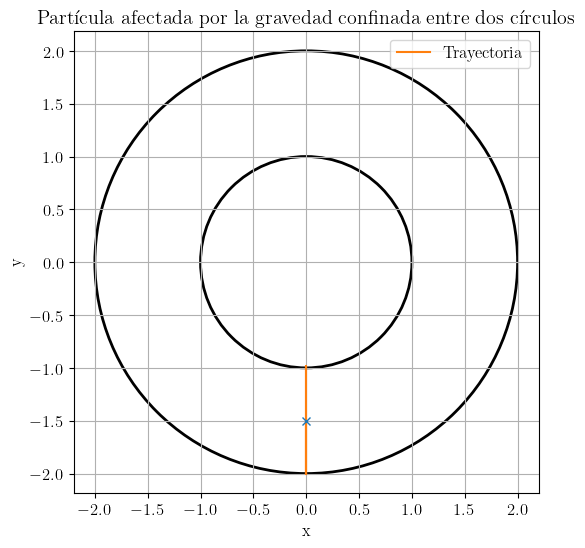

In [30]:
realizar_simulaciones_circ([1.5, -np.pi/2, 3.2, 0], 200, 40)

Sí se puede confinar la partícula a una sola sección. Esto se logra fácilmente si sólo se le imparte velocidad radial.

#### Inciso c)
¿Se pueden obtener trayectorias cerradas?, es decir, ¿existen condiciones en las que la partícula llegue eventualmente a las mismas condiciones iniciales?

Sí. Por ejemplo, si se quita la gravedad se pueden trazar polígonos regulares dentro del círculo.

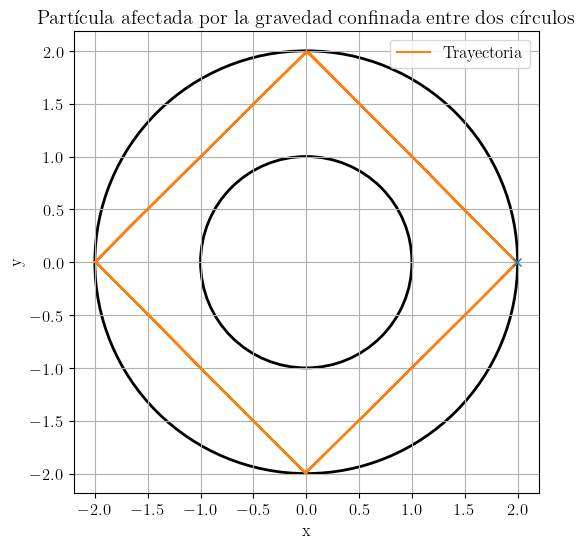

In [31]:
g = 0
realizar_simulaciones_circ([b-0.01, 0, -1.97, 1], 20, 20)